In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string
# spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud, STOPWORDS
# import sklearn
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs, fetch_openml
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from gensim import corpora, models, similarities, matutils
import scipy.sparse


In [2]:
with open('reviews.pkl', 'rb') as read_file:
    reviews_df = pickle.load(read_file)

In [3]:
with open('alltext.pkl', 'rb') as read_file:
    alltext_df = pickle.load(read_file)

# Clean Text

* remove punctuation
* strip whitespace
* remove any \n \r characters

In [5]:
# clean function
def clean_function(review_string):
    '''Input: string
    Output: cleaned string'''
    review_string = re.sub('\[.*?\]', '', review_string)
    review_string = re.sub('[%s]' % re.escape(string.punctuation), '', review_string)
    review_string = re.sub('\w*\d\w*', '', review_string)
    review_string = re.sub('[‘’“”…]', '', review_string)
    review_string = re.sub('\n', ' ', review_string)
    review_string = re.sub('\r', ' ', review_string)
    review_string = review_string.lower()
    return review_string

In [7]:
clean_reviews = lambda x: clean_function(x)

In [ ]:
data_clean = pd.DataFrame(reviews_df.comment.apply(clean_reviews))
data_clean

In [8]:
data_clean2 = pd.DataFrame(alltext_df.comment.apply(clean_reviews))
data_clean2

,comment
1,play this game play this game a lot hard to f...
2,among my favorite games to play with players ...
3,variable winning conditions make for great int...
4,great game tried with players first this ga...
5,classic game of finance and risk one of the be...
...,...
271693,very smart and surprisingly deep tile laying g...
271785,pure fun surprisingly good dexterity game with...
271869,if you prefer dice to cards the news is good s...
271896,finally the firefly board game we all wanted ...


# Spacy - Remove Stopwords
* tokenize, remove stopwords

In [38]:
spacy_nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"], max_length=3000000)
spacy_stopwords = STOP_WORDS

In [24]:
# remove spacy stopwords
def spacy_stop(string):
    doc = spacy_nlp(string)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in tokens]
    return ' '.join(tokens)

In [36]:
nostop_reviews = lambda x: spacy_stop(x)

In [ ]:
data_lemm = pd.DataFrame(data_clean.comment.apply(nostop_reviews))

# NLTK - Stopwords / Lemmatizer

In [7]:
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
# incorporate stop words when creating the count vectorizer
nltk_stopwords = stopwords.words('english')


In [8]:
# adding custom stopwords after initial topic modeling
custom_stopwords = ['la', 'en', 'el', 'para', 'se', 'lo', 'si', 'al', 'bien', 'mi',
                   'de', 'un', 'con', 'pour', 'te', 'da', 'pa', 'poco', 'hay', 'carte','about',
 'above','across','after','afterwards','again','against','all',
 'almost','alone','along','already','also','although','always','like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said','feel','lot','would','well','bit','way']
nltk_stopwords.extend(custom_stopwords)

In [12]:
# removes stopwords, compound word extraction, and lemmatization
def stop_lem(string):
    '''input string and returns lemmatized tokens
        - tokenize, remove stop words, lemmatize'''
    tokens = word_tokenize(string)
#     tokens = mwe_tokenizer.tokenize(word_tokenize(string))
    tokens = [token for token in tokens if not token in nltk_stopwords]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)
#     return tokens

In [13]:
lemmed_reviews = lambda x: stop_lem(x)

In [14]:
# remove stopwords and lemmatize text
data_lemm = pd.DataFrame(data_clean2.comment.apply(lemmed_reviews))
data_lemm

,comment
1,play game play game hard find enough player ol...
2,among favorite game play player player take tu...
3,variable winning condition make great interact...
4,great game tried player first game really shin...
5,classic game finance risk one besttry special ...
...,...
271693,smart surprisingly deep tile laying game force...
271785,pure fun surprisingly good dexterity game exce...
271869,prefer dice card news good sushi roll successf...
271896,finally firefly board game wanted star war fla...


In [15]:
words = set(nltk.corpus.words.words())
def onlyEnglish(line):
    ''' remove as much non-English words as possible with NLTK corpus and .isalpha()'''
    return " ".join(w for w in nltk.wordpunct_tokenize(line) 
         if w.lower() in words or not w.isalpha())

In [16]:
data_eng = pd.DataFrame(data_lemm.comment.apply(onlyEnglish))
data_eng

,comment
1,play game play game hard find enough player ol...
2,among favorite game play player player take tu...
3,variable winning condition make great interact...
4,great game tried player first game really shin...
5,classic game finance risk one special power be...
...,...
271693,smart surprisingly deep tile laying game force...
271785,pure fun surprisingly good dexterity game exce...
271869,prefer dice card news good roll successfully s...
271896,finally firefly board game star war flavor gre...


In [43]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [44]:
data_nouns_adj = pd.DataFrame(data_eng.comment.apply(nouns_adj))
data_nouns_adj

,comment
1,play game play game hard find enough player ol...
2,favorite game play player player turn dealer p...
3,variable condition great interaction play foot...
4,great game player game shine player bidding me...
5,classic game finance risk special power best g...
...,...
271693,smart deep tile game force plan small family game
271785,pure fun good dexterity game excellent product...
271869,prefer news good roll simplicity fun popular p...
271896,board game star war flavor great replay value ...


In [69]:
# # lemmedtext.pkl ready to pickle & process
# pickle.dump(data_eng, open("lemmedtext.pkl", "wb"))
# pickle.dump(data_nouns_adj, open("na_lemmedtext.pkl", "wb"))

In [63]:
data_eng['length'] = data_eng['comment'].str.len()

In [67]:
data_eng = data_eng.drop(columns=['length'])

# Word Cloud

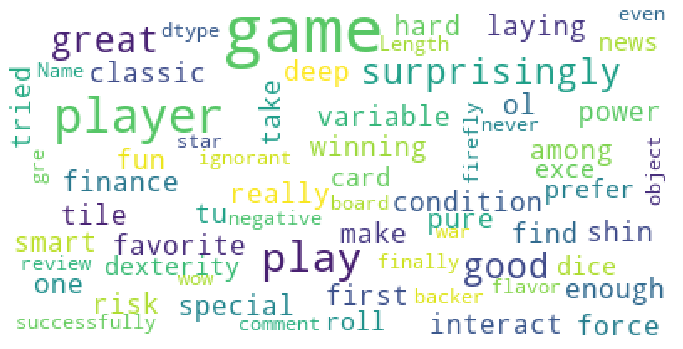

In [17]:
plt.rcParams['figure.figsize']=(12.0,12.0)  
plt.rcParams['font.size']=12            
plt.rcParams['savefig.dpi']=100             
plt.rcParams['figure.subplot.bottom']=.1 

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=nltk_stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data_eng.comment))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

# Topic Modeling

## Count Vectorizer

In [135]:
cv = CountVectorizer(stop_words=nltk_stopwords,min_df=.1,max_df=0.80,ngram_range=(1, 2))
data_cv = cv.fit_transform(data_eng.comment)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

In [141]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtm.transpose()))

id2wordna = dict((v, k) for k, v in cv.vocabulary_.items())

## LDA

In [142]:
ldana = models.LdaModel(corpus=corpusna, num_topics=7, id2word=id2wordna, passes=12)
ldana.print_topics()

[(0,
  '0.019*"tile" + 0.012*"nice" + 0.011*"simple" + 0.010*"little" + 0.009*"interesting" + 0.008*"board" + 0.008*"easy" + 0.007*"point" + 0.007*"bit" + 0.007*"abstract"'),
 (1,
  '0.022*"rule" + 0.011*"system" + 0.010*"war" + 0.010*"scenario" + 0.009*"combat" + 0.008*"battle" + 0.007*"lot" + 0.007*"well" + 0.006*"map" + 0.006*"first"'),
 (2,
  '0.015*"group" + 0.015*"people" + 0.013*"party" + 0.009*"party game" + 0.008*"dont" + 0.007*"make" + 0.007*"would" + 0.007*"lot" + 0.007*"right" + 0.006*"word"'),
 (3,
  '0.098*"card" + 0.018*"deck" + 0.013*"card game" + 0.010*"little" + 0.010*"filler" + 0.009*"quick" + 0.009*"hand" + 0.008*"simple" + 0.007*"nice" + 0.007*"easy"'),
 (4,
  '0.008*"lot" + 0.008*"action" + 0.008*"feel" + 0.008*"building" + 0.008*"mechanic" + 0.008*"theme" + 0.007*"first" + 0.007*"turn" + 0.007*"make" + 0.006*"well"'),
 (5,
  '0.037*"dice" + 0.013*"roll" + 0.012*"theme" + 0.010*"luck" + 0.010*"character" + 0.008*"lot" + 0.008*"expansion" + 0.008*"solo" + 0.007*"ma

## LSA

In [87]:
from sklearn.decomposition import TruncatedSVD

In [136]:
svd_cv = TruncatedSVD(n_components=7)
doc_top_svd_cv = svd_cv.fit_transform(data_cv)

In [137]:
feature_names_cv = cv.get_feature_names()
cv.get_feature_names()
for i in range(7):
    component = svd_cv.components_[i]
    features = [(ind, x) for ind, x in enumerate(component)]
    top_features = sorted(features, key=lambda x:x[1], reverse=True)[:10]
    top_words = [feature_names_cv[x[0]] for x in top_features]
    print ("\n Topic %d: " %(i))
    print (", ".join(top_words))


 Topic 0: 
card, lot, make, dont, love, first, well, still, strategy, would

 Topic 1: 
card, deck, card game, filler, hand, quick, magic, set, fast, wonder

 Topic 2: 
simple, filler, easy, quick, light, family, party, people, gateway, tile

 Topic 3: 
party, party game, group, people, word, best, friend, right, dont, everyone

 Topic 4: 
dice, party, party game, roll, group, people, rolling, long, character, luck

 Topic 5: 
expansion, deck, classic, gateway, still, gateway game, base, new, building, board game

 Topic 6: 
party, placement, party game, building, tile, resource, action, point, dice, people


## NMF

In [3]:
with open('lemmedtext.pkl', 'rb') as read_file:
    lem_df= pickle.load(read_file)

In [4]:
from sklearn.decomposition import NMF

In [138]:
nmf_model = NMF(7)
doc_topic = nmf_model.fit_transform(data_cv)

In [5]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''input: model, feature names from model, and number of words to return
        output: topics and number of words per topic'''
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [139]:
display_topics(nmf_model, cv.get_feature_names(), 10)


Topic  0
rule, long, lot, theme, make, love, would, feel, first, dont

Topic  1
card, deck, card game, lot, expansion, feel, building, strategy, dont, theme

Topic  2
filler, simple, quick, easy, light, little, nice, card, fast, luck

Topic  3
dice, roll, luck, rolling, lot, dice rolling, placement, die, turn, way

Topic  4
party, party game, people, group, word, card, dont, right, best, everyone

Topic  5
expansion, still, classic, gateway, easy, people, strategy, board, first, dont

Topic  6
tile, placement, strategy, lot, point, building, well, turn, mechanic, action


## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(min_df=.1,max_df=0.78, stop_words=nltk_stopwords)
doc_term_matrix = vectorizer.fit_transform(data_eng.comment)
corpus = matutils.Sparse2Corpus(doc_term_matrix.transpose())

### NMF

### with Nouns/Adj Only

In [47]:
vectorizer_na = TfidfVectorizer(min_df=.1,max_df=0.78, stop_words=nltk_stopwords)
doc_term_matrix_na = vectorizer_na.fit_transform(data_nouns_adj.comment)
# corpus_na = matutils.Sparse2Corpus(doc_term_matrix_na.transpose())

In [61]:
nmf_model = NMF(n_components=11)
doc_topic_tfidf_na = nmf_model.fit_transform(doc_term_matrix_na)
display_topics(nmf_model, vectorizer_na.get_feature_names(), 12)


Topic  0
action, theme, mechanic, point, resource, turn, board, placement, much, end, area, interesting

Topic  1
system, battle, unit, scenario, war, map, combat, counter, campaign, series, german, historical

Topic  2
card, hand, deck, filler, little, quick, trick, simple, draw, light, luck, nice

Topic  3
dice, roll, luck, die, filler, push, decision, little, quick, simple, light, nice

Topic  4
party, group, question, answer, funny, everyone, team, family, social, guess, friend, laugh

Topic  5
child, memory, adult, old, simple, year, little, family, young, cute, daughter, nice

Topic  6
tile, placement, puzzle, point, score, nice, easy, draw, family, place, luck, simple

Topic  7
abstract, piece, board, strategy, move, simple, opponent, nice, quick, little, easy, interesting

Topic  8
character, expansion, miniature, theme, deck, solo, story, monster, mechanic, fantasy, new, book

Topic  9
version, original, edition, board, classic, question, new, year, much, old, piece, variant


### All POS

In [31]:
nmf_model = NMF(n_components=9)
doc_topic_tfidf = nmf_model.fit_transform(doc_term_matrix)

In [32]:
# with 9 topics
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
action, theme, turn, interesting, building, mechanic, point, first, resource, end

Topic  1
system, battle, unit, map, scenario, war, counter, combat, campaign, series

Topic  2
card, deck, filler, hand, quick, little, draw, simple, trick, luck

Topic  3
dice, roll, rolling, luck, die, filler, push, quick, little, decision

Topic  4
party, word, question, group, answer, funny, team, laugh, friend, everyone

Topic  5
abstract, piece, board, move, strategy, simple, opponent, nice, interesting, quick

Topic  6
tile, scoring, puzzle, placement, score, point, nice, draw, easy, word

Topic  7
child, adult, memory, old, year, family, little, simple, young, daughter

Topic  8
character, expansion, miniature, love, version, theme, deck, edition, original, still


In [215]:
# with 8 topics
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
theme, lot, action, mechanic, feel, first, board, would, bit, well

Topic  1
card, deck, filler, hand, little, quick, simple, draw, luck, trick

Topic  2
system, battle, scenario, unit, map, war, counter, combat, campaign, series

Topic  3
dice, roll, rolling, luck, die, filler, push, quick, little, decision

Topic  4
party, word, question, people, group, answer, team, funny, right, laugh

Topic  5
abstract, piece, board, move, strategy, simple, opponent, interesting, nice, quick

Topic  6
tile, scoring, placement, point, score, building, nice, puzzle, luck, draw

Topic  7
child, adult, memory, old, year, family, little, simple, young, daughter


In [217]:
# create dataframe from doc_topic array
nmf_df = pd.DataFrame(doc_topic_tfidf,
             index = data_eng.index,
             columns = ["topic_1","topic_2","topic_3","topic_4",
                       "topic_5","topic_6","topic_7","topic_8"])

In [42]:
# create dataframe from doc_topic array
nmf_df2 = pd.DataFrame(doc_topic_tfidf,
             index = lem_df.index,
             columns = [0,1,2,3,4,5,6,7,8])
# ["action_top","battle_top","card_top","dice_top",
#                        "party_top","abstract_top","tile_top","fam_top","charac_top"]

In [43]:
nmf_df2['main_topic'] = nmf_df2.idxmax(axis=1)

In [68]:
# # topics ready to pickle & process
# pickle.dump(nmf_df2, open("nmfdf2.pkl", "wb"))

In [218]:
# # topics ready to pickle & process
# pickle.dump(nmf_df, open("nmfdf.pkl", "wb"))

### Visualizing NMF Topic Distribution

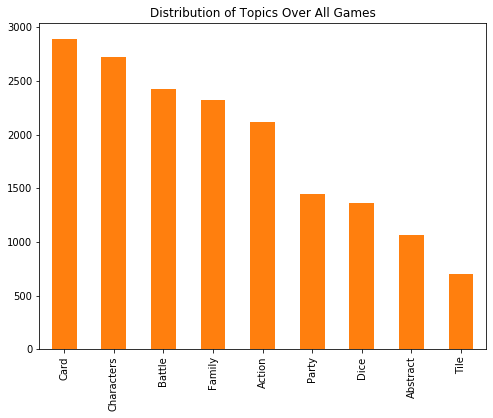

In [55]:
nmf_df2['main_topic'].value_counts().plot(kind='bar',color='tab:orange',figsize=(8,6))
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8],labels=['Card','Characters','Battle','Family','Action','Party','Dice','Abstract','Tile'])
plt.title('Distribution of Topics Over All Games')
plt.savefig('topicdist.svg',format='svg',transparent=True)
plt.show()

In [63]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=9)
result = svd.fit_transform(doc_term_matrix)
km = KMeans(n_clusters=9, max_iter=100, n_jobs =-1, n_init=1)
km.fit(result)
ypred = km.fit_predict(result)

In [87]:
import umap

In [108]:
labels = ['action','battle','card','dice','party','abstract strategy','tile','family','character']

/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/metis/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


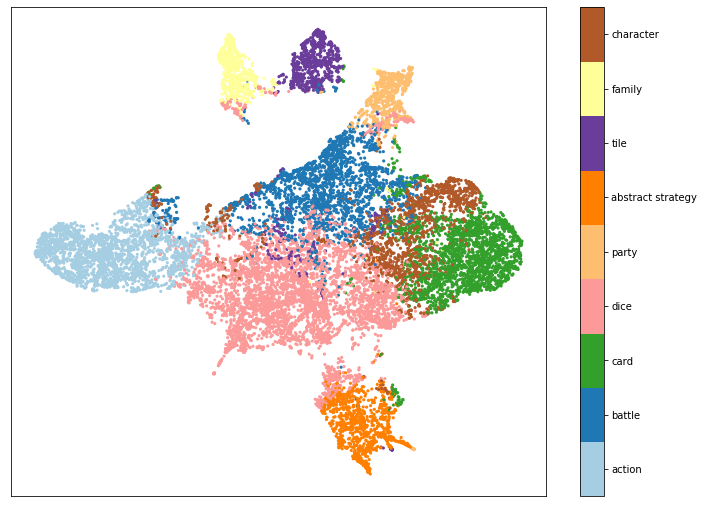

In [109]:
embedding = umap.UMAP(n_neighbors=9, min_dist=0.1, random_state=12).fit_transform(result)
fig, ax = plt.subplots(1, figsize=(12, 9))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = ypred,
s = 10, # size
edgecolor='none',
cmap='Paired'
)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(10)-0.5)
cbar.set_ticks(np.arange(9))
cbar.set_ticklabels(labels)
plt.savefig('UMAPtopicviz.svg',format='svg',transparent=True)
plt.show()

## LDA

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=9, # Number of topics    
                                      n_jobs = -1  # Use all available CPUs
                                     )

In [19]:
lda_output = lda_model.fit_transform(doc_term_matrix)

### LSA

In [146]:
svd_tfidf = TruncatedSVD(n_components=7)
doc_top_svd_tfidf = svd_tfidf.fit_transform(doc_term_matrix)

In [147]:
display_topics(svd_tfidf, vectorizer.get_feature_names(), 10)


Topic  0
card, rule, lot, little, make, theme, would, well, nice, bit

Topic  1
card, deck, filler, hand, trick, party, theme, round, draw, art

Topic  2
card, system, battle, scenario, unit, war, map, rule, counter, combat

Topic  3
dice, roll, rolling, card, luck, die, filler, battle, push, war

Topic  4
party, word, question, people, group, answer, child, adult, memory, version

Topic  5
abstract, child, filler, simple, memory, piece, adult, quick, old, little

Topic  6
tile, party, word, filler, dice, unit, battle, scoring, system, counter


# Clustering

In [ ]:
# data-structure to store Sum-Of-Square-Errors
sse = {}
# Looping over multiple values of k from 1 to 30
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50).fit(data_cv)
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_
# Plotting the curve with 'k'-value vs SSE
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

In [159]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 8)
Y_sklearn = sklearn_pca.fit_transform(doc_topic_tfidf)

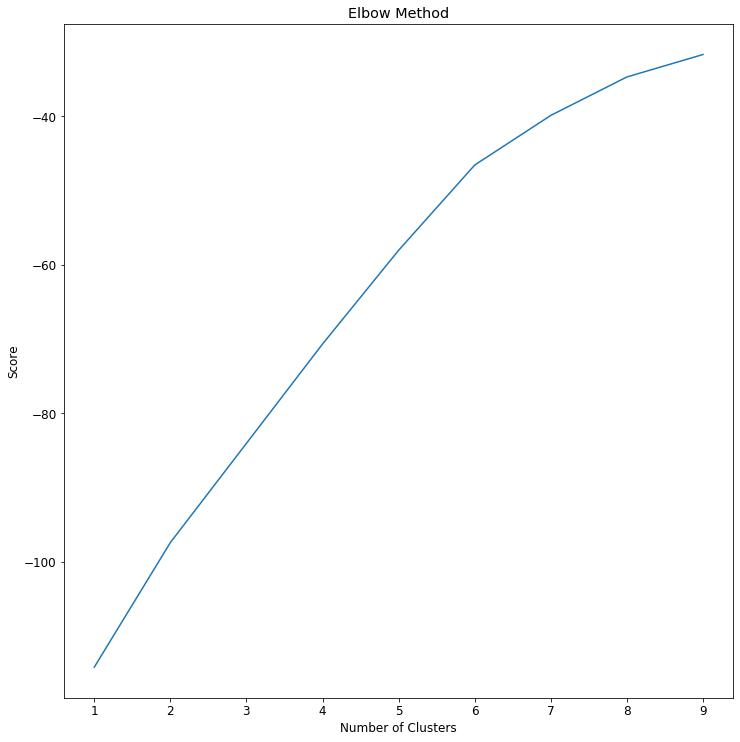

In [160]:
number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 400) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [197]:
# KMeans clustering
from sklearn.cluster import KMeans

number_of_clusters=6
km = KMeans(n_clusters=number_of_clusters).fit(doc_term_matrix)

In [198]:
km_pred = km.predict(doc_term_matrix)

In [194]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: tile abstract piece board strategy
Cluster 1: card deck filler little theme
Cluster 2: rule system unit battle map
Cluster 3: dice roll luck rolling card
Cluster 4: card party child rule little
Cluster 5: card rule theme lot make


In [195]:
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()

In [199]:
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(km_pred, doc_term_matrix, vectorizer.get_feature_names(), 15)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
dice, roll, luck, rolling, card, little, filler, make, nice, lot, simple, rule, die, quick, bit
Cluster #1:
card, party, rule, little, child, version, nice, word, lot, make, better, would, simple, love, dont
Cluster #2:
tile, abstract, piece, board, strategy, nice, simple, move, interesting, little, rule, make, bit, two, quick
Cluster #3:
card, rule, theme, lot, make, board, would, bit, well, first, interesting, feel, turn, mechanic, little
Cluster #4:
rule, system, unit, battle, map, scenario, counter, war, combat, campaign, series, german, lot, well, historical
Cluster #5:
card, deck, filler, little, theme, rule, lot, make, hand, nice, simple, interesting, would, better, bit

